## Dependencies
```
!pip install tensorflow==1.15
!pip install coremltools=4.0b2
!pip install imageio
!pip install Pillow
```

In [1]:
import os
# Don't use GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Suppress logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
import coremltools as ct
import coremltools.proto.FeatureTypes_pb2 as ft

from imageio import imread
from PIL import Image

## Download and Extract Pretrained Model

In [4]:
#@title Downloading and extracting the model checkpoints

MODEL_NAME = 'deeplabv3_xception_ade20k_train'  # @param ['deeplabv3_mnv2_ade20k_train_2018_12_03', 'deeplabv3_xception_ade20k_train']

DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
MODEL_URLS = {
    'deeplabv3_mnv2_ade20k_train_2018_12_03':
        'deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz',
    'deeplabv3_xception_ade20k_train':
        'deeplabv3_xception_ade20k_train_2018_05_29.tar.gz',
}

MODEL_TAR = MODEL_URLS[MODEL_NAME]
MODEL_URL = DOWNLOAD_URL_PREFIX + MODEL_TAR

# Download
!wget -O {MODEL_TAR} {MODEL_URL}

# Extract
MODEL_FILE = !tar -zxvf {MODEL_TAR}
MODEL_FILE = MODEL_FILE[0].strip()
print('Frozen graph file path:', MODEL_FILE)

--2020-11-16 11:24:43--  http://download.tensorflow.org/models/deeplabv3_xception_ade20k_train_2018_05_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.194.80
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.194.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460299576 (439M) [application/x-tar]
Saving to: ‘deeplabv3_xception_ade20k_train_2018_05_29.tar.gz’

deeplabv3_xception_ 100%[===================>] 438.98M  2.10MB/s    in 4m 52s  

2020-11-16 11:29:35 (1.50 MB/s) - ‘deeplabv3_xception_ade20k_train_2018_05_29.tar.gz’ saved [460299576/460299576]

Frozen graph file path: x deeplabv3_xception_ade20k_train/


## Conversion to CoreML

In [5]:
# Frozen weights
FROZEN_GRAPH_PATH = "deeplabv3_xception_ade20k_train/frozen_inference_graph.pb"

# Output path
output_filepath = "deeplabv3_xception_ade20k_train/deeplab.mlmodel"

In [6]:
image_input = ct.ImageType(shape=(1, 512, 512, 3), channel_first=False)
mlmodel = ct.convert(FROZEN_GRAPH_PATH, inputs=[image_input], source='tensorflow')

Translating MIL ==> MLModel Ops: 100%|██████████| 1952/1952 [00:02<00:00, 672.92 ops/s] 


In [7]:
mlmodel

input {
  name: "ImageTensor"
  type {
    imageType {
      width: 512
      height: 512
      colorSpace: RGB
    }
  }
}
output {
  name: "SemanticPredictions"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==1.14.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b2"
  }
}

In [8]:
# Set feature descriptions (these show up as comments in XCode)
mlmodel.input_description["ImageTensor"] = "Input RGB image of dimensions 512 x 512."
mlmodel.output_description["SemanticPredictions"] = "Segmentation map for the input image."
# Set model author name
mlmodel.author = "The Home Depot - Visual AI & HD Home"
# Set a short description for the Xcode UI
mlmodel.short_description = "Produces a segmentation map"
# Set a version for the model
mlmodel.version = "1.0"

# Save model
mlmodel.save(output_filepath)

## Change Model Data Type and Shape
This helps on the iOS side. We want a 512 x 512 INT32 output.

In [9]:
spec = ct.utils.load_spec(output_filepath)
output = spec.description.output[0]
output

name: "SemanticPredictions"
shortDescription: "Segmentation map for the input image."
type {
  multiArrayType {
    dataType: FLOAT32
  }
}

In [10]:
output.type.multiArrayType.dataType = ft.ArrayFeatureType.INT32
output.type.multiArrayType.shape.extend([512, 512])
output

name: "SemanticPredictions"
shortDescription: "Segmentation map for the input image."
type {
  multiArrayType {
    shape: 512
    shape: 512
    dataType: INT32
  }
}

In [11]:
ct.utils.save_spec(spec, output_filepath)

## Quantize Model
Quantization drastically reduces model size.

In [12]:
# Load in the model spec.
spec = ct.utils.load_spec(output_filepath)

# Quantize the model to 16-bit classification (very little loss of accuracy).
spec = ct.utils.convert_neural_network_spec_weights_to_fp16(spec)

# Save the spec into the mlmodel file.
ct.models.utils.save_spec(spec, output_filepath)

/Users/YXW4WP8/anaconda3/envs/deeplab/lib/python3.6/site-packages/coremltools/models/_deprecation.py:25: FutureWarning: Function "convert_neural_network_spec_weights_to_fp16" is deprecated and will be removed in the next release; instead use 'coremltools.models.neural_network.quantization_utils.quantize_weights'.
  warnings.warn(msg, category=FutureWarning)


Quantizing layer xception_65/entry_flow/conv1_1/Conv2Dx
Quantizing layer batch_norm_0
Quantizing layer xception_65/entry_flow/conv1_2/Conv2Dx
Quantizing layer batch_norm_1
Quantizing layer xception_65/entry_flow/block1/unit_1/xception_module/shortcut/Conv2Dx
Quantizing layer xception_65/entry_flow/block1/unit_1/xception_module/separable_conv1_depthwise/depthwisex
Quantizing layer batch_norm_2
Quantizing layer batch_norm_3
Quantizing layer xception_65/entry_flow/block1/unit_1/xception_module/separable_conv1_pointwise/Conv2Dx
Quantizing layer batch_norm_4
Quantizing layer xception_65/entry_flow/block1/unit_1/xception_module/separable_conv2_depthwise/depthwisex
Quantizing layer batch_norm_5
Quantizing layer xception_65/entry_flow/block1/unit_1/xception_module/separable_conv2_pointwise/Conv2Dx
Quantizing layer batch_norm_6
Quantizing layer xception_65/entry_flow/block1/unit_1/xception_module/separable_conv3_depthwise/depthwisex
Quantizing layer batch_norm_7
Quantizing layer xception_65/ent

Quantizing layer batch_norm_61
Quantizing layer xception_65/middle_flow/block1/unit_7/xception_module/separable_conv2_depthwise/depthwisex
Quantizing layer batch_norm_62
Quantizing layer xception_65/middle_flow/block1/unit_7/xception_module/separable_conv2_pointwise/Conv2Dx
Quantizing layer batch_norm_63
Quantizing layer xception_65/middle_flow/block1/unit_7/xception_module/separable_conv3_depthwise/depthwisex
Quantizing layer batch_norm_64
Quantizing layer xception_65/middle_flow/block1/unit_7/xception_module/separable_conv3_pointwise/Conv2Dx
Quantizing layer batch_norm_65
Quantizing layer xception_65/middle_flow/block1/unit_8/xception_module/separable_conv1_depthwise/depthwisex
Quantizing layer batch_norm_66
Quantizing layer xception_65/middle_flow/block1/unit_8/xception_module/separable_conv1_pointwise/Conv2Dx
Quantizing layer batch_norm_67
Quantizing layer xception_65/middle_flow/block1/unit_8/xception_module/separable_conv2_depthwise/depthwisex
Quantizing layer batch_norm_68
Quant

Quantizing layer batch_norm_122
Quantizing layer xception_65/exit_flow/block1/unit_1/xception_module/separable_conv2_depthwise/depthwisex
Quantizing layer batch_norm_123
Quantizing layer xception_65/exit_flow/block1/unit_1/xception_module/separable_conv2_pointwise/Conv2Dx
Quantizing layer batch_norm_124
Quantizing layer xception_65/exit_flow/block1/unit_1/xception_module/separable_conv3_depthwise/depthwisex
Quantizing layer batch_norm_125
Quantizing layer xception_65/exit_flow/block1/unit_1/xception_module/separable_conv3_pointwise/Conv2Dx
Quantizing layer batch_norm_126
Quantizing layer xception_65/exit_flow/block2/unit_1/xception_module/separable_conv1_depthwise/depthwisex
Quantizing layer batch_norm_127
Quantizing layer xception_65/exit_flow/block2/unit_1/xception_module/separable_conv1_pointwise/Conv2Dx
Quantizing layer batch_norm_128
Quantizing layer xception_65/exit_flow/block2/unit_1/xception_module/separable_conv2_depthwise/depthwisex
Quantizing layer batch_norm_129
Quantizing 

## Sanity Check
Load the model back in, make note of the input and output names and data types. The input data type should all be 512 x 512 RGB Image, output should be 512 x 512 INT32 MultiArray.

In [13]:
mlmodel = ct.models.MLModel(output_filepath)
mlmodel

input {
  name: "ImageTensor"
  shortDescription: "Input RGB image of dimensions 512 x 512."
  type {
    imageType {
      width: 512
      height: 512
      colorSpace: RGB
    }
  }
}
output {
  name: "SemanticPredictions"
  shortDescription: "Segmentation map for the input image."
  type {
    multiArrayType {
      shape: 512
      shape: 512
      dataType: INT32
    }
  }
}
metadata {
  shortDescription: "Produces a segmentation map"
  versionString: "1.0"
  author: "The Home Depot - Visual AI & HD Home"
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==1.14.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b2"
  }
}

## Test Inference
NOTE: This will only work on MacOS 10.13 or later.

Input: ImageTensor
Output:  SemanticPredictions


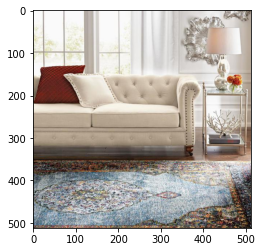

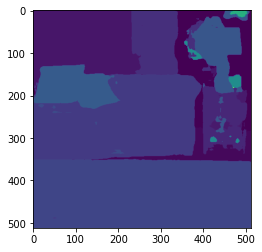

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from PIL import Image

import coremltools

img_uri = 'Figures/living_room.jpg'
img = Image.open(img_uri)

model = coremltools.models.MLModel(output_filepath)

img = img.resize([512,512], Image.ANTIALIAS)
spec = model.get_spec()
print("Input:", spec.description.input[0].name)
print("Output: ", spec.description.output[0].name)

coreml_input = {"ImageTensor": img}
coreml_outputs = model.predict(coreml_input)
segmap = coreml_outputs['SemanticPredictions']

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(segmap)
plt.show()